# Training BERT, SciBERT and PubMedBERT

## 0. Setup

### 0.1 Install libraries

In [78]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
# If you work with GPU-support:
! pip install torch==2.7.1+cu128 -f https://download.pytorch.org/whl/torch/
! pip install torchaudio==2.7.1+cu128 -f https://download.pytorch.org/whl/torchaudio/
! pip install torchvision==0.22.1+cu128 -f https://download.pytorch.org/whl/torchvision/

Looking in links: https://download.pytorch.org/whl/torch/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchaudio/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchvision/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
# If you only work with CPU-support:
# ! pip install torch==2.7.1
# ! pip install torchaudio==2.7.1
# ! pip install torchvision==0.22.1

### 0.2 GPU setup

In [81]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3070


## 1. Configuration

In [82]:
data_path = r"../../data/labeled/2025-06-28_labeled_data.xlsx"
text_column_name = "expanded"
label_column_name = "label_strict"

model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2
num_labels = 2

## 2. Read and prepare dataset

In [83]:
import pandas as pd

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA or -99
df = df[~df['label'].isna() & (df['label'] != -99)]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance the dataset: all 1s and an equal number of random 0s
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0].sample(n=len(ones), random_state=42)
df = pd.concat([ones, zeros]).sample(frac=1, random_state=42).reset_index(drop=True)

# Show head
df.head()

,text,label
0,"For groups added to the analysis, no significa...",0
1,Post hoc examination (based on standardized ch...,1
2,Groups were matched on gender (p = .108) and y...,1
3,Neither the reaction time nor the proportion o...,1
4,Among participants using the optimal strategy ...,0


### 2.1 Create Train/Test set

In [84]:
from sklearn.model_selection import train_test_split

# Separate by label
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0]

# Split each class into train/test
ones_train, ones_test = train_test_split(ones, test_size=test_size, random_state=42)
zeros_train, zeros_test = train_test_split(zeros, test_size=test_size, random_state=42)

# Combine to make balanced train/test sets
df_train = pd.concat([ones_train, zeros_train]).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat([ones_test, zeros_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

Header of the Training set:

In [85]:
df_train.head()

,text,label
0,There were no significant gender differences i...,0
1,"Step 1, in which the predictors were fine moto...",0
2,"Critically, although overall RTs were reliably...",1
3,Simple-slopes analysis showed that sAA decreas...,1
4,Only in the twin sample did a lower age of ons...,1


In [86]:
# Check label balance in training set
df_train['label'].value_counts()

label
0    263
1    263
Name: count, dtype: int64

Header of the Test set:

In [87]:
df_test.head()

,text,label
0,There was no correlation between number of ima...,1
1,There was neither a significant main effect of...,0
2,The decline in the joy condition did not diffe...,1
3,"Specifically, when infants learned faces from ...",1
4,"We did not observe a main effect of aperture, ...",0


In [88]:
# Check label balance in test set
df_test['label'].value_counts()

label
1    66
0    66
Name: count, dtype: int64

### 2.2 Tokenize 'text'

In [89]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=350)

tokenized_train = train_dataset.map(preprocess_function, batched=True)

tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 132/132 [00:00<00:00, 6292.67 examples/s]


#### 2.2.1 Comparing tokenized and untokenized statements

In [90]:
# Collect comparison data for the first 20 samples (adjust as needed)
comparison = []
for i in range(224):
    original = train_dataset[i]['text']
    input_ids = tokenized_train[i]['input_ids']
    decoded = tokenizer.decode(input_ids, skip_special_tokens=True)
    comparison.append({
        "original_text": original,
        "tokenized_ids": input_ids,
        "decoded_text": decoded
    })

# Create DataFrame
df_comparison = pd.DataFrame(comparison)

# Show header
df_comparison.head(10)

# Save to CSV
# df_comparison.to_csv("tokenization_comparison.csv", index=False)
# print("Saved as tokenization_comparison.csv")

,original_text,tokenized_ids,decoded_text
0,There were no significant gender differences i...,"[101, 2045, 2020, 2053, 3278, 5907, 5966, 1999...",there were no significant gender differences i...
1,"Step 1, in which the predictors were fine moto...","[101, 3357, 1015, 1010, 1999, 2029, 1996, 1601...","step 1, in which the predictors were fine moto..."
2,"Critically, although overall RTs were reliably...","[101, 11321, 1010, 2348, 3452, 19387, 2015, 20...","critically, although overall rts were reliably..."
3,Simple-slopes analysis showed that sAA decreas...,"[101, 3722, 1011, 10314, 4106, 3662, 2008, 784...",simple - slopes analysis showed that saa decre...
4,Only in the twin sample did a lower age of ons...,"[101, 2069, 1999, 1996, 5519, 7099, 2106, 1037...",only in the twin sample did a lower age of ons...
5,The interaction between familiarity and length...,"[101, 1996, 8290, 2090, 24666, 1998, 3091, 200...",the interaction between familiarity and length...
6,The main effect of workload was not significan...,"[101, 1996, 2364, 3466, 1997, 2147, 11066, 200...",the main effect of workload was not significan...
7,"In Experiment 2a, we submitted RT and report e...","[101, 1999, 7551, 23409, 1010, 2057, 7864, 193...","in experiment 2a, we submitted rt and report e..."
8,"Variability in movement end points, calculated...","[101, 28436, 1999, 2929, 2203, 2685, 1010, 101...","variability in movement end points, calculated..."
9,"Contingency increased pupillary dilation, t(19...","[101, 9530, 3436, 11916, 3445, 11136, 28221, 2...","contingency increased pupillary dilation, t ( ..."


## 3. Regular BERT

### 3.1 Initializing regular BERT

In [91]:
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [92]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\raphi\AppData\Local\Temp\ipykernel_1316\617370419.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [93]:
trainer_bert.train()

Step,Training Loss
66,0.684000
132,0.316400
198,0.165900
264,0.061700
330,0.017900


TrainOutput(global_step=330, training_loss=0.2491785638260119, metrics={'train_runtime': 81.3494, 'train_samples_per_second': 32.33, 'train_steps_per_second': 4.057, 'total_flos': 473034621990000.0, 'train_loss': 0.2491785638260119, 'epoch': 5.0})

#### 3.2.1 Save last model

In [94]:
# trainer_bert.save_model('bert_model')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [95]:
from sklearn.metrics import classification_report

preds = trainer_bert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       1.00      1.00      1.00       263

    accuracy                           1.00       526
   macro avg       1.00      1.00      1.00       526
weighted avg       1.00      1.00      1.00       526



#### 3.3.2 Predict test data

In [96]:
preds = trainer_bert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        66
           1       0.97      0.89      0.93        66

    accuracy                           0.93       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.93      0.93      0.93       132



#### 3.3.3 4.3.3 Confusion-Matrix for test data

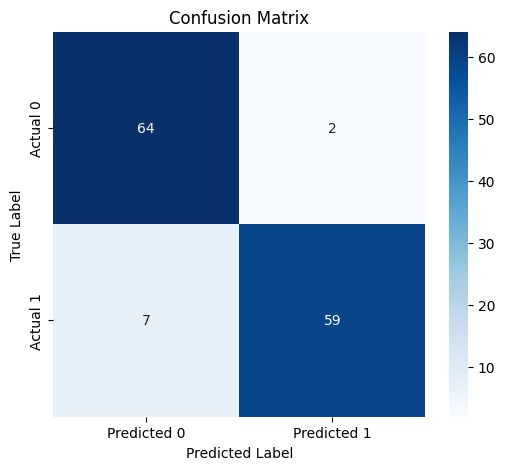

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [98]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [99]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 59)


,text
0,There was no correlation between number of ima...
1,The decline in the joy condition did not diffe...
2,"Specifically, when infants learned faces from ..."
3,"As with choices, the interaction between sure-..."
4,"When both targets were available, observers sw..."
5,"Although overall, infants had longer first fix..."
6,"This preference, however, disappeared in the e..."
7,A negative binomial regression showed no diffe...
8,There was no effect of session order for bimod...
9,"At pretest, the groups did not differ, F(2, 72..."


In [100]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 64)


,text
0,There was neither a significant main effect of...
1,The senders' overall corrugator activity was n...
2,"In contrast, there were no significant group d..."
3,The two-way interaction between CRP and cancer...
4,The alternative explanation of an order effect...
...,...
59,The Target Ã— Valence interaction was not sign...
60,"Consequently, receivers' use of the odd-oneout..."
61,A repeated measures ANOVA on the two questions...
62,Follow-up tests revealed that the AOI Ã— Varia...


In [101]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 2)


,text
0,"We did not observe a main effect of aperture, ..."
1,"Relying on the categorical approach, and again..."


In [102]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 7)


,text
0,"The omnibus ANCOVA, in which posterior perceiv..."
1,RT data showed a very similar pattern: Respons...
2,"In contrast, the mean signed response offset f..."
3,"Importantly, there were no between-group diffe..."
4,"Notably, applying the same analysis to the dat..."
5,"Gender, trait aggression, and endogenous testo..."
6,There was no relationship between risk taking ...


## 4. SciBERT

### 4.1 Initializing SciBERT

In [103]:
from transformers import AutoModelForSequenceClassification

model_scibert = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Training SciBERT

In [104]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_scibert = Trainer(
    model=model_scibert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\raphi\AppData\Local\Temp\ipykernel_1316\2136063693.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_scibert = Trainer(


In [105]:
trainer_scibert.train()

Step,Training Loss
66,0.702900
132,0.503700
198,0.295300
264,0.159300
330,0.086300


TrainOutput(global_step=330, training_loss=0.3494987487792969, metrics={'train_runtime': 107.8898, 'train_samples_per_second': 24.377, 'train_steps_per_second': 3.059, 'total_flos': 473034621990000.0, 'train_loss': 0.3494987487792969, 'epoch': 5.0})

#### 4.2.1 Save last model

In [106]:
# trainer_scibert.save_model('scibert_model')

### 4.3 Evaluate model

#### 4.3.1 Predict training data

In [107]:
from sklearn.metrics import classification_report

preds = trainer_scibert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       263
           1       1.00      0.98      0.99       263

    accuracy                           0.99       526
   macro avg       0.99      0.99      0.99       526
weighted avg       0.99      0.99      0.99       526



#### 4.3.2 Predict test data

In [108]:
preds = trainer_scibert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88        66
           1       0.90      0.85      0.88        66

    accuracy                           0.88       132
   macro avg       0.88      0.88      0.88       132
weighted avg       0.88      0.88      0.88       132



#### 4.3.3 Confusion-Matrix for test data

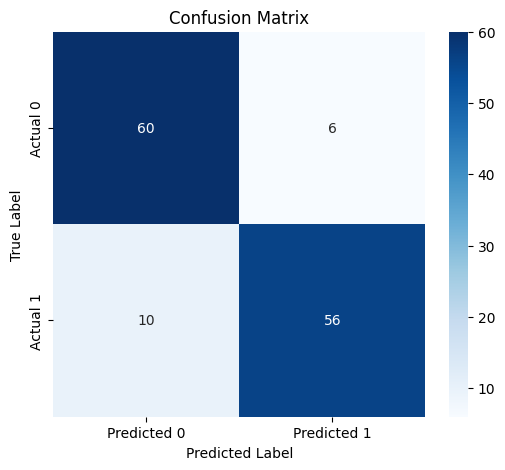

In [109]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 4.3.4 List of statements per category (TP, TN, FP, FN)

In [110]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [111]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 56)


,text
0,There was no correlation between number of ima...
1,The decline in the joy condition did not diffe...
2,"Specifically, when infants learned faces from ..."
3,"As with choices, the interaction between sure-..."
4,"When both targets were available, observers sw..."
5,"Although overall, infants had longer first fix..."
6,"This preference, however, disappeared in the e..."
7,A negative binomial regression showed no diffe...
8,There was no effect of session order for bimod...
9,"At pretest, the groups did not differ, F(2, 72..."


In [112]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 60)


,text
0,There was neither a significant main effect of...
1,The senders' overall corrugator activity was n...
2,"In contrast, there were no significant group d..."
3,The alternative explanation of an order effect...
4,"By contrast, leader narcissism levels were not..."
5,"Specifically, stronger Republicans were less l..."
6,"However, polarization scores were somewhat str..."
7,In the second block of tests in this experimen...
8,We found no significant difference between the...
9,The Kruskal-Wallis test on average indicated t...


In [113]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 6)


,text
0,"We did not observe a main effect of aperture, ..."
1,The two-way interaction between CRP and cancer...
2,RT from the visual discrimination phase was ag...
3,"Relying on the categorical approach, and again..."
4,Post hoc tests of the effect of trait aggressi...
5,We also did not detect an interaction between ...


In [114]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 10)


,text
0,The average accuracy in the scene-categorizati...
1,"The omnibus ANCOVA, in which posterior perceiv..."
2,"Across the experiments, the holistic-processin..."
3,A rank-based Spearman's correlation test (p < ...
4,"The three-way interaction was not significant,..."
5,"In contrast, the mean signed response offset f..."
6,"Notably, applying the same analysis to the dat..."
7,"In reward blocks, the results of Experiment 1 ..."
8,"Gender, trait aggression, and endogenous testo..."
9,"We found, first of all, that risk preferences ..."


## 5. PubMedBERT

### 5.1 Initializing PubMedBERT

In [115]:
from transformers import AutoModelForSequenceClassification

model_pubmedbert = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2 Training PubMedBERT

In [116]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_pubmedbert = Trainer(
    model=model_pubmedbert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\raphi\AppData\Local\Temp\ipykernel_1316\2526163365.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmedbert = Trainer(


In [117]:
trainer_pubmedbert.train()

Step,Training Loss
66,0.718100
132,0.670400
198,0.451700
264,0.319500
330,0.191300


TrainOutput(global_step=330, training_loss=0.47018953670154917, metrics={'train_runtime': 117.9955, 'train_samples_per_second': 22.289, 'train_steps_per_second': 2.797, 'total_flos': 473034621990000.0, 'train_loss': 0.47018953670154917, 'epoch': 5.0})

#### 5.2.1 Save last model

In [118]:
# trainer_pubmedbert.save_model('pubmedbert_model')

### 5.3 Evaluate model

#### 5.3.1 Predict training data

In [128]:
from sklearn.metrics import classification_report

preds = trainer_pubmedbert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       263
           1       0.95      0.98      0.96       263

    accuracy                           0.96       526
   macro avg       0.96      0.96      0.96       526
weighted avg       0.96      0.96      0.96       526



#### 5.3.2 Predict test data

In [129]:
preds = trainer_pubmedbert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        66
           1       0.75      0.82      0.78        66

    accuracy                           0.77       132
   macro avg       0.78      0.77      0.77       132
weighted avg       0.78      0.77      0.77       132



#### 5.3.3 Confusion-Matrix for test data

In [135]:
GT

[1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0]

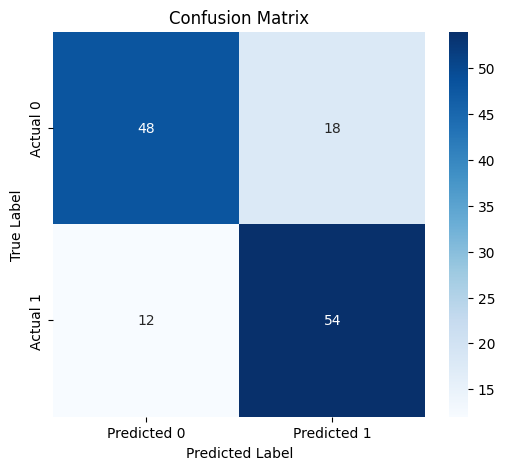

In [121]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 5.3.4 List of statements per category (TP, TN, FP, FN)

In [122]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [123]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 54)


,text
0,There was no correlation between number of ima...
1,The decline in the joy condition did not diffe...
2,"Specifically, when infants learned faces from ..."
3,"As with choices, the interaction between sure-..."
4,"When both targets were available, observers sw..."
5,"Although overall, infants had longer first fix..."
6,"This preference, however, disappeared in the e..."
7,A negative binomial regression showed no diffe...
8,There was no effect of session order for bimod...
9,"At pretest, the groups did not differ, F(2, 72..."


In [124]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 48)


,text
0,There was neither a significant main effect of...
1,The senders' overall corrugator activity was n...
2,"In contrast, there were no significant group d..."
3,The alternative explanation of an order effect...
4,"By contrast, leader narcissism levels were not..."
5,"Specifically, stronger Republicans were less l..."
6,In the second block of tests in this experimen...
7,We found no significant difference between the...
8,"Further, there were no significant differences..."
9,There was not a significant difference between...


In [125]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 18)


,text
0,"We did not observe a main effect of aperture, ..."
1,The two-way interaction between CRP and cancer...
2,"However, polarization scores were somewhat str..."
3,The Kruskal-Wallis test on average indicated t...
4,"For the mid-scale questions, we found no diffe..."
5,The effect of host-country tightness was not s...
6,A 2 (condition: adversarial vs. benevolent) Ã—...
7,RT from the visual discrimination phase was ag...
8,Controlling for relationship satisfaction did ...
9,"In contrast, non-White AI faces (left side of ..."


In [126]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 12)


,text
0,"CloudResearch sample, b = 1.23, 95% CI = [0.24..."
1,ANOVAs within blocks revealed that during the ...
2,Identifiability increased vicarious optimism s...
3,"However, the orientation selected during false..."
4,"The omnibus ANCOVA, in which posterior perceiv..."
5,"The model was not significant, Ï‡ 2 (3, N = 90..."
6,The number of incongruent negative and positiv...
7,"The three-way interaction was not significant,..."
8,"In contrast, the mean signed response offset f..."
9,"Importantly, there were no between-group diffe..."


In [ ]:
# The end...